<a href="https://colab.research.google.com/github/DCDPUAEM/DCDP/blob/main/03%20Machine%20Learning/notebooks/11-Reduccion-Dimensionalidad.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reducción de dimensionalidad

Recuerda la simbología de las secciones:

* 🔽 Esta sección no forma parte del proceso usual de Machine Learning. Es una exploración didáctica de algún aspecto del funcionamiento del algoritmo.
* ⚡ Esta sección incluye técnicas más avanzadas destinadas a optimizar o profundizar en el uso de los algoritmos.
* ⭕ Esta sección contiene un ejercicio o práctica a realizar. Aún si no se establece una fecha de entrega, es muy recomendable realizarla para practicar conceptos clave de cada tema.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Maldición de la dimensionalidad

En este experimento generaremos puntos aleatorios en espacios de diferentes dimensiones y calcularemos las distancias euclidianas entre ellos. Conforme aumenta la dimensionalidad, observaremos cómo todas las distancias tienden a volverse muy similares entre sí, perdiendo la capacidad de discriminar entre puntos "cercanos" y "lejanos". Este fenómeno, conocido como la maldición de la dimensionalidad, explica por qué muchos algoritmos de machine learning (como k-NN o clustering) pierden efectividad en espacios de alta dimensión.

In [ ]:
#@title Experimento maldición de la dimensionalidad
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

np.random.seed(42)
side = 10
n_puntos = 100
dims = list(range(2, 500, 3))
n_repetitions = 5

average_distances = []
min_distances = []
max_distances = []
std_distances = []
relative_std = []  # Desviación estándar relativa (coeficiente de variación)

for i, dim in enumerate(dims):
    exp_avg, exp_min, exp_max, exp_std = [], [], [], []

    for _ in range(n_repetitions):
        puntos = np.random.uniform(size=(n_puntos, dim), low=-side, high=side)
        distances = pdist(puntos, metric='euclidean')

        exp_avg.append(np.mean(distances))
        exp_min.append(np.min(distances))
        exp_max.append(np.max(distances))
        exp_std.append(np.std(distances))

    # Promediar los experimentos
    avg_dist = np.mean(exp_avg)
    average_distances.append(avg_dist)
    min_distances.append(np.mean(exp_min))
    max_distances.append(np.mean(exp_max))
    std_distances.append(np.mean(exp_std))

    # Coeficiente de variación (desviación estándar relativa)
    relative_std.append(np.mean(exp_std) / avg_dist)


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('La Maldición de la Dimensionalidad: Convergencia de Distancias', fontsize=16)

# 1. Distancias absolutas:
ax1.plot(dims, average_distances, 'b-', linewidth=2, label='Distancia promedio')
ax1.plot(dims, min_distances, 'g--', linewidth=2, label='Distancia mínima')
ax1.plot(dims, max_distances, 'r--', linewidth=2, label='Distancia máxima')
ax1.fill_between(dims, min_distances, max_distances, alpha=0.2, color='gray')
ax1.set_xlabel('Dimensiones')
ax1.set_ylabel('Distancia Euclidiana')
ax1.set_title('Evolución de las Distancias')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Razón máximo/mínimo:
ratio_max_min = np.array(max_distances) / np.array(min_distances)
ax2.plot(dims, ratio_max_min, 'purple', linewidth=2)
ax2.set_xlabel('Dimensiones')
ax2.set_ylabel('Ratio Distancia Máx/Mín')
ax2.set_title('Convergencia: Ratio Distancia Máxima/Mínima')
ax2.grid(True, alpha=0.3)

# 3. Coeficiente de variación:
ax3.plot(dims, relative_std, 'orange', linewidth=2)
ax3.set_xlabel('Dimensiones')
ax3.set_ylabel('Coeficiente de Variación')
ax3.set_title('Variabilidad Relativa de las Distancias')
ax3.grid(True, alpha=0.3)

# 4. Distribución de distancias para dimensiones específicas
sample_dims = [3, 10, 100, 1000]
colors = ['blue', 'green', 'orange', 'red']

for dim, color in zip(sample_dims, colors):
    puntos_sample = np.random.uniform(size=(n_puntos, dim), low=-side, high=side)
    distances_sample = pdist(puntos_sample, metric='euclidean')
    ax4.hist(distances_sample,alpha=0.6, color=color,edgecolor='black',
            label=f'{dim}D', density=True, linewidth=0.5)

ax4.set_xlabel('Distancia Euclidiana')
ax4.set_ylabel('Densidad de Probabilidad')
ax4.set_title('Distribución de Distancias por Dimensionalidad')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Esto nos dice que si tenemos *muchas* features, usar distancias entre vectores se vuelve algo cada vez menos significativo. **Reducir features** se vuelve muy útil para combatir este problema, podemos hacerlo:

1. **Seleccionando features** (selección de features): [`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html), [`RFE`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html), [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html)

2. **Proyectando en espacios de menor dimensión** (reducción de dimensionalidad): [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [`TSNE`](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), [`UMAP`](https://umap-learn.readthedocs.io/), [`TruncatedSVD`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)

En esta notebook analizaremos la segunda estrategia.

# 🔽 Ejemplos ilustrativos

## PCA

Exploremos cómo funciona [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) y los resultados que produce.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.datasets import make_circles, make_blobs
import matplotlib.pyplot as plt

#------- definimos el dataset -------
X,y = make_blobs(n_samples=500, centers=2, random_state=11)
idxs = np.where(y==0)[0]
X[idxs,:] = X[idxs,:] + [[8,5]]
idxs = np.where(y==1)[0]
X[idxs,:] = X[idxs,:] + [[-7,2]]
#-------------------------------------


#----- Aplicamos PCA ----------
pca = PCA()
X_red = pca.fit_transform(X)  # No entrenamos con las etiquetas
#------------------------------


#-------- Graficamos ----------
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].title.set_text("Dataset original")
axs[0].scatter(X[:,0],X[:,1],color='blue')
axs[1].title.set_text("Dataset original y componentes principales")
axs[1].scatter(X_red[:,0],X_red[:,1],alpha=0.25,color='orange',label="PCA (PC 1,2)")
axs[1].scatter(X_red[:,0],[0 for x in X_red],color='green',label="PCA (PC 1)")
axs[1].scatter(X[:,0],X[:,1],alpha=0.4,color='blue',label="Original set")
# Dibujamos los ejes
axs[1].axhline(0,color='gray',linestyle='--')
axs[1].axvline(0,color='gray',linestyle='--')
axs[1].legend(loc='best')
fig.tight_layout()
fig.show()

In [ ]:
#@title Graficar en HTML un dataset en 3D usando plotly

import numpy as np
from sklearn.datasets import make_blobs
import plotly.graph_objects as go
import plotly.io as pio


n_samples = 300  # Total de puntos (100 por blob)
n_features = 3    # 3 dimensiones
centers = 3       # 3 blobs

X3d, y3d = make_blobs(n_samples=n_samples,
                  n_features=n_features,
                  centers=centers,
                  cluster_std=1.5,
                  random_state=42)


fig = go.Figure()

# Añadir cada blob como una traza separada (para colores distintos)
for i in range(centers):
    fig.add_trace(go.Scatter3d(
        x=X[y == i, 0],
        y=X[y == i, 1],
        z=X[y == i, 2],
        mode='markers',
        marker=dict(
            size=5,
            opacity=0.8
        ),
        name=f'Blob {i+1}'
    ))

fig.update_layout(
    title='3 Blobs en 3D',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600
)

# Guardar como HTML
pio.write_html(fig, file='blobs_3d.html', auto_open=True)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_red = pca.fit_transform(X3d)

plt.figure(figsize=(10,6))
plt.title("Dataset visualizado con 2 PC")
plt.scatter(X_red[:,0],X_red[:,1],c=y3d)
plt.show()

En este ejemplo podemos ver la perdida de información del conjunto original.

In [ ]:
from sklearn.datasets import make_moons

X,_ = make_moons(n_samples=500,random_state=1945,noise=0.1)

X = X + [[3,3]]  # Trasladamos todo el dataset para fines de visualización

pca = PCA()
X_red = pca.fit_transform(X)

fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].title.set_text("Dataset original")
axs[0].scatter(X[:,0],X[:,1],color='blue')
axs[1].title.set_text("Dataset original y componentes principales")
axs[1].scatter(X_red[:,0],X_red[:,1],alpha=0.25,color='orange',label="PCA (PC 1,2)")
axs[1].scatter(X_red[:,0],[0 for x in X_red],color='green',label="PCA (PC 1)")
axs[1].scatter(X[:,0],X[:,1],alpha=0.4,color='blue',label="Original set")
# Dibujamos los ejes
axs[1].axhline(0,color='gray')
axs[1].axvline(0,color='gray')
axs[1].legend(loc='best')
fig.tight_layout()
fig.show()

## t-SNE

La implementación de t-SNE se encuentra en [`sklear.manifold.TSNE`](https://scikit-learn.org/0.16/modules/generated/sklearn.manifold.TSNE.html)

In [ ]:
from sklearn.manifold import TSNE

* Observar que t-SNE centra los datos en el origen.
* Es diferente hacer t-SNE con dos componentes y tomar la primera, a hacerlo con una componente.

In [ ]:
from sklearn.datasets import make_circles, make_blobs

X,_ = make_blobs(n_samples=1000, centers=1, random_state=1945)

tsne = TSNE(n_components=2)
X_red_2 = tsne.fit_transform(X)
print(X_red_2.shape)

tsne = TSNE(n_components=1)
X_red_1 = tsne.fit_transform(X)
print(X_red_1.shape)

fig, axs = plt.subplots(1,2,figsize=(10,5))
axs[0].title.set_text("Dataset original")
axs[0].scatter(X[:,0],X[:,1],color='blue')
axs[1].title.set_text("Dataset original y componentes principales")
axs[1].scatter(X_red_2[:,0],X_red_2[:,1],alpha=0.25,color='orange',label="t-SNE 2dim")
axs[1].scatter(X_red_1[:,0],[0 for x in X_red_1],alpha=0.25,color='green',label="t-SNE 1dim")
axs[1].scatter(X[:,0],X[:,1],alpha=0.4,color='blue',label="Original set")
# Dibujamos los ejes
axs[1].axhline(0,color='gray',linestyle='--')
axs[1].axvline(0,color='gray',linestyle='--')
axs[1].legend(loc='best')
fig.tight_layout()
fig.show()

Veamos el efecto del hiper-parámetro `perplexity`. Está relacionado con el número de vecinos de cada punto que se toman en cuenta, entre más grande sea el dataset, ḿas grande suele tomarse el parámetro.

In [ ]:
from sklearn.datasets import make_circles, make_blobs

X,_ = make_blobs(n_samples=1000, centers=2, random_state=1945)

tsne = TSNE(n_components=2,perplexity=5)
X_red_2 = tsne.fit_transform(X)

tsne = TSNE(n_components=1,perplexity=5)
X_red_1 = tsne.fit_transform(X)

tsne = TSNE(n_components=2,perplexity=50)
X_red_3 = tsne.fit_transform(X)

tsne = TSNE(n_components=1,perplexity=50)
X_red_4 = tsne.fit_transform(X)

fig, axs = plt.subplots(2,2)
axs[0,0].title.set_text("Dataset original")
axs[0,0].scatter(X[:,0],X[:,1],color='blue')
axs[0,1].title.set_text("TSNE 2-dim y 1-dim")
axs[0,1].scatter(X_red_2[:,0],X_red_2[:,1],alpha=0.25,color='orange')
axs[0,1].scatter(X_red_1[:,0],[0 for x in X_red_1],alpha=0.25,color='green')
# Dibujamos los ejes
axs[0,1].axhline(0,color='gray',linestyle='--')
axs[0,1].axvline(0,color='gray',linestyle='--')

axs[1,0].scatter(X[:,0],X[:,1],color='blue')
axs[1,1].scatter(X_red_3[:,0],X_red_3[:,1],alpha=0.25,color='orange')
axs[1,1].scatter(X_red_4[:,0],[0 for x in X_red_4],alpha=0.25,color='green')
# Dibujamos los ejes
axs[1,1].axhline(0,color='gray',linestyle='--')
axs[1,1].axvline(0,color='gray',linestyle='--')

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.show()

In [ ]:
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500,random_state=1945,noise=0.1)

tsne = TSNE(n_components=1,perplexity=35)
X_red_A = tsne.fit_transform(X)

tsne = TSNE(n_components=1,perplexity=7)
X_red_B = tsne.fit_transform(X)

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].title.set_text("Dataset original")
axs[0].scatter(X[:,0],X[:,1],c=y)
axs[1].title.set_text("TSNE: high perplexity")
axs[1].scatter(X_red_A[:,0],[0 for x in X_red_A],c=y)
axs[2].title.set_text("TSNE: low perplexity")
axs[2].scatter(X_red_B[:,0],[0 for x in X_red_B],c=y)
fig.tight_layout()
fig.show()

Recordemos el dataset en 3 dimensiones

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
X_red = tsne.fit_transform(X3d)

plt.figure(figsize=(10,6))
plt.title("Dataset visualizado con t-SNE")
plt.scatter(X_red[:,0],X_red[:,1],c=y3d)
plt.show()


## ⚡ UMAP

Uniform Manifold Approximation and Projection (UMAP) es una técnica de reducción dimensional que puede utilizarse para la visualización de forma similar a t-SNE, pero también para la reducción dimensional no lineal general. El algoritmo se basa en tres hipótesis sobre los datos

* Los datos se distribuyen uniformemente en una variedad Riemanniana.
* La métrica Riemanniana es localmente constante (o puede aproximarse como tal).
* La variedad es localmente conexa.

A partir de estos supuestos, es posible modelizar el colector con una estructura topológica difusa. La incrustación se encuentra buscando una proyección de baja dimensión de los datos que tenga la estructura topológica difusa equivalente más cercana posible.

Los detalles pueden verse en [pre-print de ArXiv](https://arxiv.org/abs/1802.03426):

In [ ]:
!pip install -qq umap-learn

Algunos parámetros importantes de UMAP:

* `n_neighbors`: Número de vecinos en los que se basa para aprender la estructura de los datos. Valores bajos de n_neighbors forzarán a UMAP a concentrarse en la estructura muy local, mientras que valores grandes empujarán a UMAP a mirar vecindarios más grandes de cada punto cuando estime la estructura múltiple de los datos, perdiendo la estructura fina.
* `min_dist` controla lo ajustado que UMAP puede representar los puntos. Controla la distancia mínima entre los puntos en la representación de baja dimensión.

In [ ]:
from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

X,y = make_moons(n_samples=500,random_state=1945,noise=0.1)

umap = UMAP(n_components=1,n_neighbors=50)
X_red_1 = umap.fit_transform(X)

umap = UMAP(n_components=1,n_neighbors=5)
X_red_2 = umap.fit_transform(X)

fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].title.set_text("Dataset original")
axs[0].scatter(X[:,0],X[:,1],c=y)
axs[1].title.set_text("UMAP: high n_neighbors")
axs[1].scatter(X_red_1[:,0],[0 for x in X_red_1],c=y)
axs[2].title.set_text("UMAP: low n_neighbors")
axs[2].scatter(X_red_2[:,0],[0 for x in X_red_2],c=y)
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.show()

In [ ]:
umap = UMAP(n_components=1,
            n_neighbors=50,
            min_dist=0.9)
X_red_1 = umap.fit_transform(X)

umap = UMAP(n_components=1,
            n_neighbors=50,
            min_dist=0.1)
X_red_2 = umap.fit_transform(X)

fig, axs = plt.subplots(1,3,figsize=(12,4))
axs[0].title.set_text("Dataset original")
axs[0].scatter(X[:,0],X[:,1],c=y)
axs[1].title.set_text("UMAP: high min_dist")
axs[1].scatter(X_red_1[:,0],[0 for x in X_red_1],c=y)
axs[2].title.set_text("UMAP: low min_dist")
axs[2].scatter(X_red_2[:,0],[0 for x in X_red_2],c=y)
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()
fig.show()

In [ ]:
from umap import UMAP
import matplotlib.pyplot as plt

umap = UMAP(n_components=2)
X_red = umap.fit_transform(X3d)

plt.figure(figsize=(10,6))
plt.title("Dataset visualizado con UMAP")
plt.scatter(X_red[:,0],X_red[:,1],c=y3d)
plt.show()

# Práctica 1: MNIST

En esta práctica aplicaremos reducción de dimensionalidad al conjunto de datos MNIST completo. Usaremos dos técnicas:

1. PCA
2. TSNE

En cada una de ellas visualizaremos los datos y observaremos algunos fenómenos. Además, veremos cómo afecta la dimensionalidad y el tamaño de un dataset a estos algoritmos.

In [ ]:
import numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

In [ ]:
x_train[0]

Veamos las escalas de valores de los datos

In [ ]:
import pandas as pd

pd.DataFrame(x_train.reshape(-1,28*28)).describe()

In [ ]:
all_pixels = x_train.reshape(-1,)

max = np.max(all_pixels)
min = np.min(all_pixels)

print(f"Valor máximo: {max}")
print(f"Valor mínimo: {min}")

plt.figure()
plt.hist(all_pixels)
plt.show()

Realizamos preprocesamiento:
* Dividimos todo entre 255
* Hacemos el reshape adecuado, cada ejemplo es un vector de 784 componentes

**Importante**: PCA es muy susceptible a escalas diferentes entre variables

In [ ]:
X_train = x_train.reshape(-1,28*28) / 255.
X_test = x_test.reshape(-1,28*28) / 255.

Veamos algunos ejemplos

In [ ]:
import matplotlib.pyplot as plt

random_idxs = np.random.randint(0, x_train.shape[0], 6)

fig, axs = plt.subplots(2, 3, figsize=(10, 6))
for i, idx in enumerate(random_idxs):
    axs[i // 3, i % 3].imshow(x_train[idx].reshape(28, 28), cmap='gray')
    axs[i // 3, i % 3].set_title(f"Label: {y_train[idx]}")
    axs[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

## 1. PCA

Ahora, apliquemos PCA a los datos. De esta manera, reducimos la dimensión de los puntos, de 784 a sólo 2.

**Importante**:

* Observa que entrenamos a PCA con el conjunto de entrenamiento y el conjunto de prueba, sólo lo transformamos con el modelo ya entrenado.
* Estamos en aprendizaje no supervisado, aquí, en principio no tenemos etiquetas, o más precisamente, no las usamos para los entrenamientos.

![alt text](https://drive.google.com/uc?id=1S9KVyZbkiciIEeC7cLi-epa62gfFM0pi )

⭕ ¿Por qué no entrenar con todo el conjunto de datos?

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_red = pca.fit_transform(x_train)    # Sólo entrenamos con el de entrenamiento
X_test_red = pca.transform(x_test)          # Sólo transformamos el de prueba

print(X_train_red.shape)
print(X_test_red.shape)

Ya podemos ver cómo se ve el conjunto de entrenamiento y prueba, separado por clases.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4),dpi=100)
plt.subplot(1, 2, 1)
plt.title("Training data")
for k in range(10):
  plt.scatter(X_train_red[y_train==k, 0], X_train_red[y_train==k, 1], label=k)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.subplot(1, 2, 2)
plt.title("Test data")
for k in range(10):
  plt.scatter(X_test_red[y_test==k, 0], X_test_red[y_test==k, 1], label=k)
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_train_red_3 = pca.fit_transform(x_train)    # Sólo entrenamos con el de entrenamiento
X_test_red_3 = pca.transform(x_test)          # Sólo transformamos el de prueba

print(X_train_red.shape)
print(X_test_red.shape)

In [ ]:
#@title Graficar PCA 3D

import plotly.express as px
import pandas as pd
import plotly.io as pio

# Crear DataFrame para Plotly
df = pd.DataFrame({
    'PC1': X_train_red_3[:, 0],
    'PC2': X_train_red_3[:, 1],
    'PC3': X_train_red_3[:, 2],
    'Digit': y_train.astype(str)
})

# Crear el gráfico 3D
fig = px.scatter_3d(
    df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Digit',
    color_discrete_sequence=px.colors.qualitative.Light24,
    title='MNIST en 3D (PCA)'
)

# Personalizar el gráfico
fig.update_layout(
    scene=dict(
        xaxis=dict(showgrid=False, showbackground=False, showticklabels=True, title='PC1'),
        yaxis=dict(showgrid=False, showbackground=False, showticklabels=True, title='PC2'),
        zaxis=dict(showgrid=False, showbackground=False, showticklabels=True, title='PC3'),
        bgcolor='white'
    ),
    legend_title_text='Dígito',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Guardar como HTML
pio.write_html(fig, file='mnist_pca_3d.html', auto_open=True)

### ⚡ Varianza explicada

Veamos la varianza agregada por cada una de las primeras 20 componentes principales, usando el atributo `explained_variance_ratio_` de la clase PCA.

Este es un arreglo que contiene la varianza, como fracción, asociada a cada componente principal. En el caso de nuestro modelo, son dos componentes principales, por lo que es un arreglo de dos componentes.

In [ ]:
pca.explained_variance_ratio_

Entre estas dos componentes explican alrededor del 16% de la varianza de los datos.

In [ ]:
np.sum(pca.explained_variance_ratio_)

Veamos como es la varianza explicada considerando 20 componentes principales. Para esto, tenemos primero que entrenar un nuevo modelo de PCA, con 20 componentes principales.

In [ ]:
pca = PCA(n_components=20).fit(x_train)

Graficamos la contribución acumulada de la varianza en cada componente principal

In [ ]:
xs = list(range(1, pca.explained_variance_ratio_.shape[0]+1))

plt.bar(xs, pca.explained_variance_ratio_)
plt.xticks(xs)
plt.plot(xs, np.cumsum(pca.explained_variance_ratio_), marker='o',color='red')
plt.grid()
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada")
print(f"Varianza explicada por cada una de las componentes principales:\n{pca.explained_variance_ratio_}\n")
print(f"Varianza acumulada explicada por cada una de las componentes principales:\n{np.cumsum(pca.explained_variance_ratio_)}\n")

Varianza de todas las componentes principales.

In [ ]:
pca = PCA(n_components=784).fit(x_train)

In [ ]:
xs = list(range(1, pca.explained_variance_ratio_.shape[0]+1))

plt.figure(figsize=(16, 3))
plt.bar(xs, pca.explained_variance_ratio_)
plt.plot(xs, np.cumsum(pca.explained_variance_ratio_), '--',color='red')
plt.grid()
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada")
plt.show()

¿Con cuántas componentes principales conseguiríamos 95% de la varianza?

In [ ]:
maxPC = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.95)[0][0]
print(f"El 95% de la varianza se obtiene con {maxPC} componentes principales\n")

xs = list(range(1, pca.explained_variance_ratio_.shape[0]+1))

plt.figure(figsize=(16, 3))
plt.plot(xs, np.cumsum(pca.explained_variance_ratio_), color='red')
plt.axhline(0.95,color='gray',linestyle='--')
plt.axvline(maxPC,color='gray',linestyle='--')
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada")
plt.show()

🔵 Si queremos entrenar un clasificador, ¿es mejor entrenar en los datos 2-dimensionales, en el conjunto completo o en un conjunto intermedio?

**Observación importante**: En PCA, es lo mismo hacer reducción de dimensionalidad con un número de componentes $m$, que hacer reducción de dimensianalidad con un número de componentes $n\geq m$ y luego tomar las primeras $m$.

Por ejemplo, podemos hacer reducción de dimensionalidad con todas las componentes principales y luego tomar solamente las que necesitemos.

**Conclusión**

* PCA es rápido
* Es lineal
* Capta la estructura global del conjunto de datos
* Podemos medir la varianza acumulada

## 2. t-SNE

Ahora, exploremos [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) "t-distributed Stochastic Neighbor Embedding".

Este método puede ser más tardado con una cantidad grande de datos y dimensiones, por lo que podemos tomar una muestra de los datos originales. Esta muestra consta de los primeros 5000 datos, el entrenamiento tarda alrededor de 1 minuto.

In [ ]:
train_sample_size = 5000

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_train_red = tsne.fit_transform(x_train[:train_sample_size])
print(X_train_red.shape)

🔵 Observar que t-SNE no tiene un método `transform`, ¿qué significa esto?

Transformemos el conjunto de datos dos veces, de manera independiente para observar la naturaleza probabilística del método.

In [ ]:
test_sample_size = 2000

X_test_red_1 = TSNE(n_components=2).fit_transform(x_test[:test_sample_size])
print(X_test_red_1.shape)

X_test_red_2 = TSNE(n_components=2).fit_transform(x_test[:test_sample_size])
print(X_test_red_2.shape)

In [ ]:
plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
plt.title("Datos de entrenamiento")
for k in range(10):
    plt.scatter(X_train_red[y_train[:train_sample_size]==k, 0], X_train_red[y_train[:train_sample_size]==k, 1], label=k)
plt.legend()
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.title("Datos de prueba - Primer entrenamiento")
for k in range(10):
    plt.scatter(X_test_red_1[y_test[:test_sample_size]==k, 0],
                X_test_red_1[y_test[:test_sample_size]==k, 1],
                label=k)
plt.xticks([])
plt.yticks([])
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Test data - Segundo entrenamiento")
for k in range(10):
    plt.scatter(X_test_red_2[y_test[:test_sample_size]==k, 0],
                X_test_red_2[y_test[:test_sample_size]==k, 1],
                label=k)
plt.xticks([])
plt.yticks([])
plt.legend()

plt.show()

Ahora hagamos reducción de dimensionalidad a 3 dimensiones con T-SNE

⏱ Tarda alrededor de 3-5 minutos

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3)
X_train_red_3 = tsne.fit_transform(x_train[:train_sample_size])
print(X_train_red_3.shape)

In [ ]:
#@title Graficar PCA 3D

import plotly.express as px
import pandas as pd
import plotly.io as pio

y_red  = y_train[:train_sample_size]

# Crear DataFrame para Plotly
df = pd.DataFrame({
    'PC1': X_train_red_3[:, 0],
    'PC2': X_train_red_3[:, 1],
    'PC3': X_train_red_3[:, 2],
    'Digit': y_red.astype(str)
})

# Crear el gráfico 3D
fig = px.scatter_3d(
    df,
    x='PC1',
    y='PC2',
    z='PC3',
    color='Digit',
    color_discrete_sequence=px.colors.qualitative.Light24,
    title='MNIST en 3D (PCA)'
)

# Personalizar el gráfico
fig.update_layout(
    scene=dict(
        xaxis=dict(showgrid=False, showbackground=False, showticklabels=True, title='PC1'),
        yaxis=dict(showgrid=False, showbackground=False, showticklabels=True, title='PC2'),
        zaxis=dict(showgrid=False, showbackground=False, showticklabels=True, title='PC3'),
        bgcolor='white'
    ),
    legend_title_text='Dígito',
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Guardar como HTML
pio.write_html(fig, file='mnist_tsne_3d.html', auto_open=True)

**Conclusión**

* T-SNE es lento
* T-SNE no es lineal
* Su principal parámetros en `perplexity`
* No siempre va a dar el mismo resultado
* Capta la estructura local y global, es decir, trata de preservar las distribuciones de distancias entre puntos.


## ⭕ Práctica

Entrenaremos un clasificador para el dataset MNIST de Keras. Es un dataset grande y balanceado. Te enfrentarás, por primera vez, al problema de la dimensionalidad y el tamaño.

* Entrena un clasificador con estas representaciones 2-dimensionales de los datos de entrenamiento. Usa PCA.
* Reporta las métricas de clasificación sobre el conjunto de prueba: Accuracy, y F1-score.
* Aumenta el número de componentes de la reducción de dimensionalidad con el objetivo de tener mejores métricas de rendimiento.
* Finalmente, realiza la tarea de clasificación usando todas las dimensiones.

¿Con qué features tuviste mejores desempeños? ¿qué reducción de dimensionalidad funcionó mejor?

**Opcional:** Realiza un grid-search para obtener el mejor número de dimensiones, de forma que se maximice el accuracy.

#### Pasos de la práctica


Dataset: Observa que, la versión completa, ya está dividida en train/test

In [ ]:
#---- Versión reducida del dataset ----

# from sklearn.datasets import load_digits

# digits = load_digits()
# X = digits.data
# y = digits.target
# print(X.shape)
# print(y.shape)

#----- Versión completa del dataset ----

from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

🟢 Preprocesamiento: Reescalamos todo el dataset dividiendo entre 255

In [ ]:
X_train = X_train.reshape(-1,28*28)/255.
X_test = X_test.reshape(-1,28*28)/255.

🔴 Realiza PCA para reducir el dataset a 2 dimensiones, es decir a 2 features. Imprime el shape de los conjuntos resultantes para asegurarte del proceso

Recuerda:
* Entrena y transforma el conjunto de entrenamiento
* Transforma solamente el conjunto de prueba

In [ ]:
from sklearn.decomposition import PCA



🔴 Entrena un clasificador, el que prefieras, con esta versión de 2 features. Reporta el accuracy y f1-score en el conjunto de entrenamiento y prueba.

Recuerda:
* SVM es buena opción pero lento
* Decision Tree es rápido pero propenso a overfitting
* K-NN es rápido pero le afecta la alta dimensionalidad


In [ ]:
from sklearn.metrics import accuracy_score, f1_score


print(f"Train accuracy: {accuracy_score(y_train,y_pred_train)}")
print(f"Train f1-score: {f1_score(y_train,y_pred_train,average='micro')}")  # Observa el hiperparámetro 'micro'

print(f"Test accuracy: {accuracy_score(y_test,y_pred)}")
print(f"Test f1-score: {f1_score(y_test,y_pred,average='micro')}") # Observa el hiperparámetro 'micro'

🔴 Ahora:

1. Realiza PCA con un número mayor de componentes principales $10\leq d\leq 100$
2. Entrena un modelo usando el mismo algoritmo del paso anterior y vuelve a reportar las métricas, tanto en entrenamiento y prueba.

🔴 Ahora, intenta entrenar un modelo con todas las features, es decir, con el dataset original.

#### Opcional: Busqueda de hiper-parámetros

⚡ Dado que no es necesario correr PCA en cada iteración y sólo basta con calcular todas las 64 PC, podemos hacer el grid search de la siguiente forma:

# Práctica 2: Documentos de Wikipedia

Descubrir temas es útil para diversos fines, como agrupar documentos, organizar contenido disponible en línea para recuperar información y hacer recomendaciones.

**El modelado de temas** (topic modelling) es una técnica de minería de texto que proporciona métodos para descubrir temas ocultos en el documento, anotar los documentos con estos temas y organizar una gran cantidad de datos no estructurados. Numerosos proveedores de contenido y agencias de noticias están utilizando modelos de temas para recomendar artículos a los lectores.

**<h4>Objetivo de la práctica</h4>**

Usar la técnica de reducción de dimensionalidad PCA con el propósito de modelar documentos y medir semejanzas entre ellos.

Usaremos el modelo de bolsa de palabras (BoW -- Bag of words), que da como resultado una matriz documento-término que representa documentos en función del conteo de términos.

Tomaremos algunos documentos y recuperaremos los documentos más similares. Evaluaremos esta tarea usando la observación directa de los documentos.

## Conjuntos de datos

Este conjunto de datos completo puede encontrarse [aquí](https://www.cs.upc.edu/~nlp/wikicorpus/). Estos archivos son tipo texto con el contenido raw del texto.

*Para propósitos de esta sesión, solo usamos un archivo arbitrario de esta colección y lo presentamos ya preparado en un dataframe.*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/DCDPUAEM/DCDP/main/03%20Machine%20Learning/data/spanish-wikipedia-dataframe.csv"

df = pd.read_csv(url, index_col=0)
df.drop(columns=['doc_id'],inplace=True)
df

,Texto
0,amaury iii señor montfort amaury conde évreux ...
1,ruud janssen tilburg july artista holandés flu...
2,grandes crónicas francia compilación obras his...
3,san miguel basauri grupo barrios tomado barrio...
4,río perené corto río perú constituye parte sup...
...,...
4018,iese puede hacer referencia siguiente institut...
4019,cygni abreviado cyg sistema estelar triple loc...
4020,acrónimo ima puede referirse instituto mundo á...
4021,eleonora cassano buenos aires enero bailarina ...


Con este dataset, usaremos la reducción de dimensionalidad para encontrar similitudes entre documentos.

## **Extracción de características**

Tratemos de visualizar algunas propiedades de los documentos.

Para ello vamos a utilizar un contador ([Counter](https://docs.python.org/2/library/collections.html#collections.Counter)). Un contador es un contenedor que almacena elementos como claves de diccionario, y sus recuentos se almacenan como valores de diccionario.

Construiremos una columna con el conteo de palabras por documento y otra con la palabra más frecuente en el documento.

**Observación**: Podríamos saltarnos esto y hacerlo directamente con CountVectorizer, pero lo haremos para tener una forma de validación de los datos. Además, de mostrar una forma muy básica de tokenizar y realizar algunas tareas básicas de procesamiento de texto.

In [ ]:
df['Total'] = df['Texto'].apply(lambda x: len(x.split()))

df = df.sort_values(by="Total",ascending=False)
df.reset_index(drop=True,inplace=True)
df.head()

,Texto,Total
0,campeonato mundial pesos pesados boxeo generad...,11586
1,cali oficialmente santiago cali capital depart...,6637
2,monarquía británica monarquía compartida artíc...,5790
3,guerra grecia antigua frase usada describir gu...,4471
4,nombre sirna siglas inglés small interfering r...,3895


### Reducción del tamaño de las matrices

Para reducir la complejidad espacial de nuestro ejercicio, podemos hacer dos cosas:
1. Un muestreo aleatorio de documentos, lo que nos ayudaría a reducir el vocabulario.
2. Un recorte en el número de documentos por la cantidad de palabras.

Usaremos el segundo enfoque.

Obtenemos el vocabulario.
Para ello vamos a usar el método de tokenización de NLTK [`word_tokenize`](https://www.nltk.org/api/nltk.tokenize.word_tokenize.html)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from nltk.tokenize import word_tokenize

textos = df['Texto'].values
textos = " ".join(textos)
vocabulario = list(set(word_tokenize(textos))) # Manera de quitar las repeticiones de una lista
print(len(vocabulario),'palabras únicas (tokens)')

108650 palabras únicas (tokens)


Veamos el vocabulario

In [ ]:
vocabulario

Estrategia para quitar repeticiones

In [ ]:
a = [1,2,4,3,2,2,1,3]
list(set(a))

[1, 2, 3, 4]

Veamos la distribución de número de palabras por documentos

Promedio: 235.27392493164305


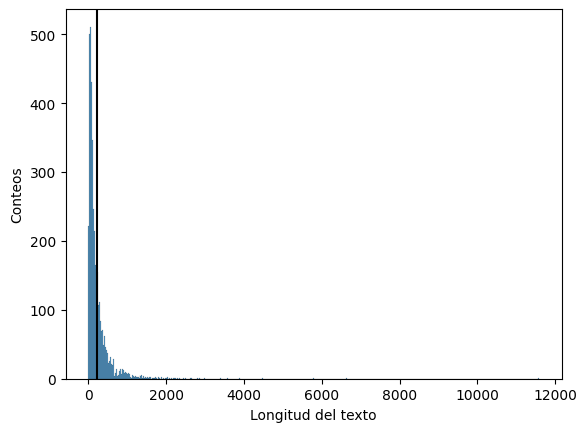

In [ ]:
from seaborn import histplot
import numpy as np

longitudes = df['Total'].values
promedio = np.mean(longitudes)
print(f"Promedio: {promedio}")

fig = plt.figure()
ax = plt.subplot()
ax.axvline(promedio,color='black')
histplot(longitudes,ax=ax)
ax.set_xlabel("Longitud del texto")
ax.set_ylabel("Conteos")
plt.show()

⚡Ejemplo de transformar los datos con el logaritmo. Esto puede hacerse cuando se tienen datos en diferentes ordenes de longitud.

In [ ]:
log_longs = np.log(longitudes)
log_promedio = np.log(promedio)
print(f"Logaritmo del promedio: {np.log(promedio)}")

fig = plt.figure()
ax = plt.subplot()
histplot(log_longs,ax=ax)
ax.axvline(log_promedio,color='black')
ax.set_xlabel("Logaritmo de la longitud del texto")
ax.set_ylabel("Conteos")
plt.show()

Filtramos algunos documentos de acuerdo a la longitud del texto. Nos quedamos con textos que tengan entre 50 y 200 palabras

In [ ]:
df = df[(df['Total'] < 200) & (df['Total'] > 50)]
print(f"Número de documentos con los que nos quedamos: {df.shape[0]}")
df.reset_index(drop=True,inplace=True)
df

Número de documentos con los que nos quedamos: 1920


,Texto,Total
0,benjamín jowett nació abril londres inglaterra...,199
1,torralba oropesa municipio españa comunidad au...,199
2,título original trujillo poder jefe iii título...,199
3,ángel uribe sánchez ancón idem futbolista peru...,199
4,site map sitemap archivo xml lista páginas sit...,199
...,...,...
1915,this the best day ever mejor día novena pista ...,51
1916,castro valnera pico situado sector central cor...,51
1917,nicholson adams hispanista estadounidense cate...,51
1918,robert bobby mann dundee escocia enero futboli...,51


Veamos, otra vez, la distribución de número de palabras por documentos.

Promedio: 109.57083333333334


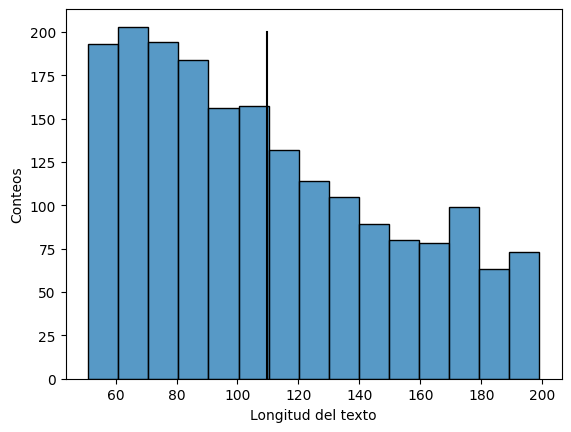

In [ ]:
from seaborn import histplot

longitudes = df['Total'].values
promedio = np.mean(longitudes)
print(f"Promedio: {promedio}")

fig = plt.figure()
ax = plt.subplot()
ax.plot([promedio,promedio],[0,200],color='black')
histplot(longitudes,ax=ax)
ax.set_xlabel("Longitud del texto")
ax.set_ylabel("Conteos")
plt.show()

⚡ Guardamos el dataframe en formato pickle. Pickle es un formato binario en el cual podemos facilmente recuperar los tipos de cada columna. Se guarda y se recupera el objeto *tal como es*.

❗ Es importante tener precaución al usarlo por la compatibilidad entre versiones.

In [ ]:
df.to_pickle('data_frame.pickle')

Leemos el dataframe previamente almacenado

In [ ]:
df = pd.read_pickle('data_frame.pickle')
df.head()

### Modelo *Bag of Words* (BoW)

Usaremos el modelo BOW de conteos de ocurrencias de palabras que hemos usado para generar features de texto, al igual que antes, usaremos el `CountVectorizer` de scikit-learn.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

docs_list = df['Texto'].values

cv = CountVectorizer(max_features=None)
X_bow = cv.fit_transform(docs_list)
X_bow.shape

(1920, 43448)

## PCA

Ahora, realizaremos PCA a la matriz de conteos.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='auto')

X_pca = pca.fit_transform(np.asarray(X_bow.todense()))

Observa la forma de la matriz obtenida, ¿cuántas componentes principales se obtienen? ¿cuántas *deberíamos* de obtener?

Esta diferencia tiene que ver con el `svd_solver` usado dado el tamaño de la matriz.

In [ ]:
print(X_pca.shape)

(1920, 1920)


Veamos la proporción de varianza por cada componente principal.

In [ ]:
pca_variance_ratio = pca.explained_variance_ratio_
print(pca_variance_ratio[:5])
print(f"Varianza acumulada: {np.sum(pca_variance_ratio)}")

[0.009512   0.00863585 0.00764301 0.00705976 0.00679065]
Varianza acumulada: 0.9999999999999998


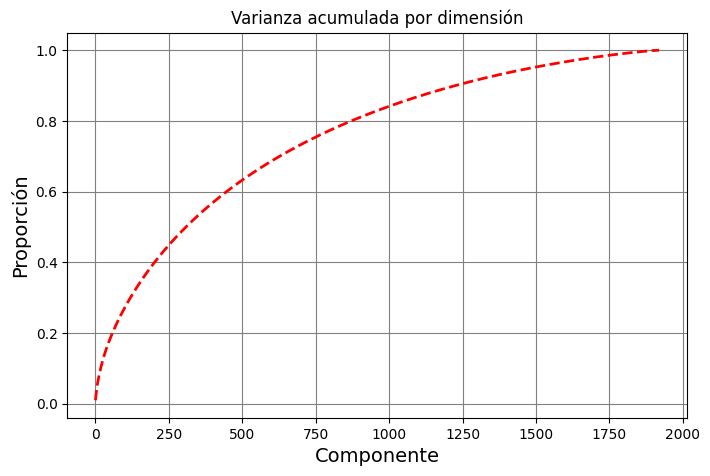

In [ ]:
# Varianza acumulada
d = np.cumsum(pca_variance_ratio)

# Graficamos
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(range(pca_variance_ratio.shape[0]),d,
        ls='--',
        color='red',
        linewidth=2,
        )

plt.title('Varianza acumulada por dimensión')
plt.xlabel('Componente',fontsize=14)
plt.ylabel('Proporción',fontsize=14)
plt.grid(True)
ax.grid(which='major', color='gray', linestyle='-')
plt.show()

### Análisis usando PCA

En esta sección, queremos saber que tan bien podemos modelar documentos utilizando estas técnicas de reducción de dimensionalidad. En la sesión pasada ya vimos algunas limitantes de modelar texto usando solamente las matrices de conteos.

Para nuestro fin, eligiremos un número $q$ de componentes principales (que llamaremos _representativas_) para PCA y compara la calidad de los documentos más cercanos (semejantes) a los documentos de análisis mostrados aquí abajo.

## Modelación de documentos utilizando componentes principales

Grafiquemos las primeras dos componentes principales del *corpus*.

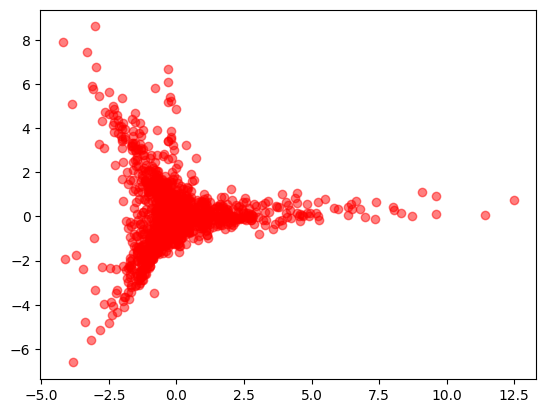

In [ ]:
plt.figure()
plt.scatter(X_pca[:,0],X_pca[:,1],alpha=0.5,c='red')
plt.show()

## Tarea: Similitud entre documentos

Escojamos los `n_test_docs=5` documentos para analizar y encontrar sus `n_vecinos_cercanos=2` vecinos más cercanos.

Definimos los parámetros del experimento

In [ ]:
import numpy as np

n_test_docs = 5
n_vecinos_cercanos = 2

test_idxs = np.random.choice(df.index.to_list(),size=n_test_docs,replace=False)
print(f"índices de los documentos para probar: {test_idxs}")

índices de los documentos para probar: [ 297   46  161 1604 1781]


In [ ]:
for idx in test_idxs:
    print(f"{idx}:\n\t {df.loc[idx,'Texto']}")

297:
	 ley multiculturalismo act for the preservation and enhancement multiculturalism canada ley promulgada reconoce oficialmente naturaleza multicultural sociedad canadiense objetivos reconocer promover entendimiento multiculturalismo refleja diversidad racial cultural sociedad canadiense reconoce libertad miembros sociedad canadiense preservar realzar compartir patrimonios culturales reconocer promover entendimiento multiculturalismo característica fundamental patrimonio identidad canadienses provee recurso formador futuro canadá invaluable promover participación total equitativa individuos comunidades orígenes continua evolución formación aspectos sociedad canadiense así asistirles eliminación barreras tal participación reconocer existencia comunidades cuyos miembros comparten origen común así contribución histórica sociedad canadiense realzar desarrollo asegurar individuos reciban igual trato igual protección bajo ley respetando valorizando diversidad alentar asistir instituciones

Funciones que calculan el vecino más cercano a cada uno de los documentos de análisis, usando la distancia Euclidiana en las representaciones obtenidas por PCA.

Esto lo hacemos usando [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors), el cual es un algoritmo para buscar eficientemente vecinos más cercanos en diversas métricas.

In [ ]:
from sklearn.neighbors import NearestNeighbors

def k_vecinos_mas_cercanos(X,idxs,k=1):
    '''
    Esta función recibe una matriz X con la representación vectorial de cada documento,
    'idxs' es la lista de índices de los documentos de los cuales se obtendran los vecinos más
    cercanos.
    'k' es el número de vecinos cercanos que se buscarán
    La función regresa una lista de parejas (idx, índices de los vecinos más cercanos a idx)
    '''
    knn = NearestNeighbors(n_neighbors=k+1,
                           metric='cosine'  # Para tareas de texto la métrica coseno suele ser mejor
                           )
    knn.fit(X)
    nns = knn.kneighbors(X[idxs], return_distance=False)
    nns_idxs = [pair[1:] for pair in nns]
    nns_ids = [(int(query_idx),nn_idxs) for query_idx,nn_idxs in
               zip(idxs,nns_idxs)]
    return nns_ids

In [ ]:
dim = 100  # elegimos un numero q de componentes principales
X_pca_red = X_pca[:,:dim]
print(X_pca_red.shape)

results = k_vecinos_mas_cercanos(X_pca_red,test_idxs,k=2)
print(results)

(1920, 100)
[(297, array([ 219, 1725])), (46, array([506, 303])), (161, array([ 376, 1574])), (1604, array([1455, 1787])), (1781, array([1675, 1807]))]


In [ ]:
for nn in results:
    test_doc = df.loc[nn[0],'Texto']
    print(f"Texto de prueba:\n\t{test_doc}")
    nn_docs = df.loc[nn[1],'Texto']
    print(f"{n_vecinos_cercanos} vecinos más cercanos:")
    for nn in nn_docs:
        print(f"\t{nn}")
    print(30*'-')

Texto de prueba:
	ley multiculturalismo act for the preservation and enhancement multiculturalism canada ley promulgada reconoce oficialmente naturaleza multicultural sociedad canadiense objetivos reconocer promover entendimiento multiculturalismo refleja diversidad racial cultural sociedad canadiense reconoce libertad miembros sociedad canadiense preservar realzar compartir patrimonios culturales reconocer promover entendimiento multiculturalismo característica fundamental patrimonio identidad canadienses provee recurso formador futuro canadá invaluable promover participación total equitativa individuos comunidades orígenes continua evolución formación aspectos sociedad canadiense así asistirles eliminación barreras tal participación reconocer existencia comunidades cuyos miembros comparten origen común así contribución histórica sociedad canadiense realzar desarrollo asegurar individuos reciban igual trato igual protección bajo ley respetando valorizando diversidad alentar asistir in

Veamos las parejas de documentos más cercanos, usando las primeras dos PC.

In [ ]:
#@title Definición de los colores para mostrar los documentos con colores diferentes

n_colors = n_test_docs

cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/n_colors) for i in range(n_colors)]

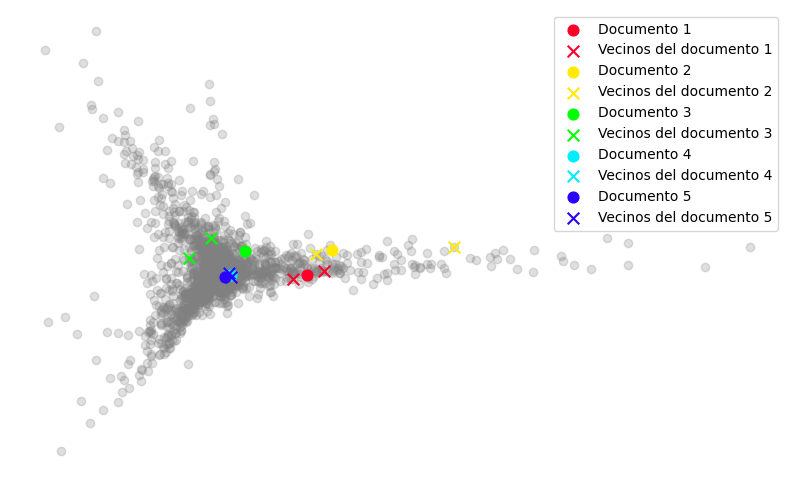

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0],X_pca[:,1], color='gray', alpha=0.25)
for j,(color,nn) in enumerate(zip(colors,results)):
    test_idx = nn[0]
    plt.scatter(X_pca[test_idx,0],X_pca[test_idx,1], color=color,s=60,label=f"Documento {j+1}")  # Graficar las primeras dos PC de los documentos de prueba
    ns_idxs = nn[1]
    plt.scatter(X_pca[ns_idxs,0],X_pca[ns_idxs,1], color=color,s=70,marker='x',label=f'Vecinos del documento {j+1}') # Graficar las primeras dos PC de los vecinos de los documentos de prueba
plt.legend()
plt.axis('off')
plt.show()

⭕ Preguntas

* ¿Por qué los vecinos no son los más cercanos en la figura?
* ¿Qué parámetros podríamos variar para modificar o mejorar estos resultados?

___

🔵 Observa las gráficas HTML de reducción de dimensionalidad de documentos. ¿Observas similitudes entre documentos *cercanos*?

* https://github.com/DCDPUAEM/DCDP/blob/main/03%20Machine%20Learning/figuras/wiki-bow-tsne3d-docs.html
* https://github.com/DCDPUAEM/DCDP/blob/main/03%20Machine%20Learning/figuras/wiki-tfidf-umap3d-docs.html